In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
import scipy
from scipy.stats import ttest_ind


# Part 1: Data Cleaning

In [26]:
raw_data = r"./data/raw_data.csv"
raw_data = pd.read_csv(raw_data)
data = raw_data[2:].copy()
data = data[data['DistributionChannel'] != 'preview']
data.reset_index(inplace=True)
data.drop(columns=['index', 'StartDate', 'Status', 'Progress', 'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId', 'UserLanguage',  'Q12 - Topics',
       'Q12 - Parent Topics', 'Q12 - Topic Hierarchy Level 1', 'EndDate'] , inplace=True)

print(data.columns)
display(data.head(5))

survey_data = data.copy()

# file_name = r'./data/MKTG390_Group2_Tacovore_Data.xlsx'

# with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
#     raw_data.to_excel(writer, sheet_name='Raw Data', index=False)
#     survey_data.to_excel(writer, sheet_name='Clean Data', index=False) 

Index(['DistributionChannel', 'Q2_1', 'Q3', 'Q4_1', 'Q5', 'Q8_1', 'Q8_2',
       'Q8_3', 'Q11', 'Q12', 'Q13', 'Q14_1', 'Q15', 'Q16', 'Q16_3_TEXT',
       'InstagramVersion', 'MenuVersion'],
      dtype='object')


,DistributionChannel,Q2_1,Q3,Q4_1,Q5,Q8_1,Q8_2,Q8_3,Q11,Q12,Q13,Q14_1,Q15,Q16,Q16_3_TEXT,InstagramVersion,MenuVersion
0,anonymous,Somewhat agree,Special promotions or discounts.,Agree,No,Somewhat agree,Strongly agree,Strongly agree,15,Tacos,Lots of different tacos,2,3rd Year,Male,NaN,A,B
1,anonymous,Agree,Seeing a targeted advertisement on social media.,Neither agree nor disagree,No,Strongly disagree,Strongly disagree,Strongly disagree,15,"Grilled Chicken, Old E, Mole Verde",They look good but also tacos I could just mak...,2,3rd Year,Female,NaN,A,A
2,anonymous,Agree,Opportunities to try a wider variety of food o...,Neither agree nor disagree,Yes,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,15,3 ish separate tacos,Very well spread healthy and accesable,1,3rd Year,Male,NaN,B,B
3,anonymous,Somewhat disagree,Special promotions or discounts.,Agree,Yes,Neither agree nor disagree,Somewhat disagree,Neither agree nor disagree,13,Mix and match tacos,It looks like there is a good amount of option...,2,3rd Year,Male,NaN,B,A
4,anonymous,Neither agree nor disagree,Special promotions or discounts.,Disagree,No,Somewhat agree,Strongly agree,Somewhat agree,13,3 mix and match tacos,Good descriptions and mix of food. The letteri...,2,3rd Year,Male,NaN,A,A


In [27]:
survey_data['InstagramVersion'] = (survey_data['InstagramVersion']
                                         .str.replace('A', 'Reel')
                                         .str.replace('B', 'Post')
                                         )

survey_data['MenuVersion'] = (survey_data['MenuVersion']
                                       .str.replace('A', "Deal Included")
                                       .str.replace('B', 'No Deal')
                                       )

survey_data['Q11'] = pd.to_numeric(survey_data['Q11'])

In [28]:
clean_data = survey_data[['Q2_1', 'Q3', 'Q4_1', 'Q5', 'Q8_1', 'Q8_2', 'Q8_3',
       'Q11', 'Q12', 'Q13', 'Q14_1', 'Q15', 'Q16', 'Q16_3_TEXT',
       'InstagramVersion', 'MenuVersion']]
clean_data.columns

Index(['Q2_1', 'Q3', 'Q4_1', 'Q5', 'Q8_1', 'Q8_2', 'Q8_3', 'Q11', 'Q12', 'Q13',
       'Q14_1', 'Q15', 'Q16', 'Q16_3_TEXT', 'InstagramVersion', 'MenuVersion'],
      dtype='object')

# Part 2: Demographic Questions

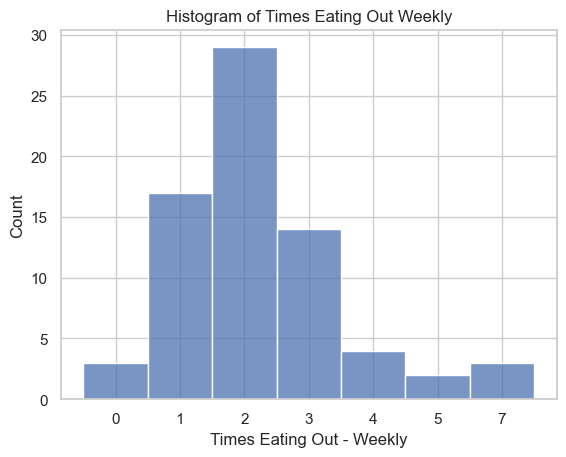

In [29]:
eat_out_count = survey_data['Q14_1']
sorted_eat_out_count = eat_out_count.sort_values(ascending=True)
sns.histplot(sorted_eat_out_count)
plt.title('Histogram of Times Eating Out Weekly')
plt.xlabel("Times Eating Out - Weekly")
plt.show()

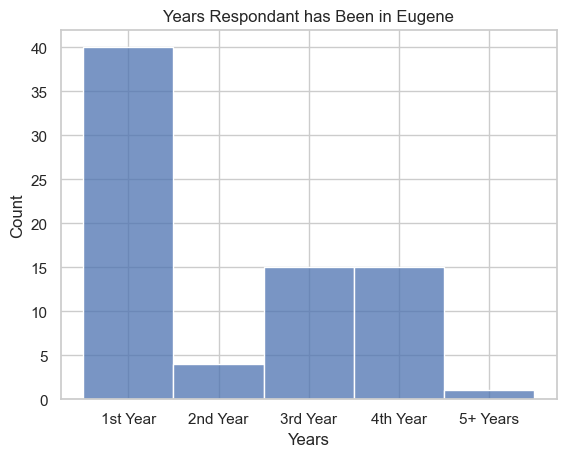

In [30]:
time_in_eugene = survey_data['Q15'].to_frame().rename(columns={'Q15': 'Time'})
time_in_eugene.dropna(inplace=True)
time_in_eugene['Time Int'] = (time_in_eugene['Time']
                              .str.extract(r'(\d+)')
                              .astype(int))
time_in_eugene.sort_values('Time Int', ascending=True, inplace=True)

sns.histplot(data=time_in_eugene, x='Time')
plt.title("Years Respondant has Been in Eugene")
plt.xlabel("Years")
plt.show()

,Gender,Q16_3_TEXT


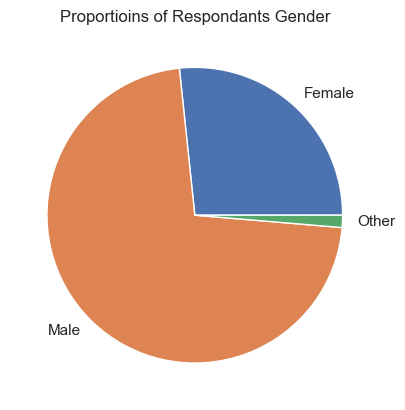

In [31]:
gender_data = survey_data[['Q16', 'Q16_3_TEXT']].rename(columns={'Q16': 'Gender'})
display(gender_data.dropna())
gender_group = (gender_data
                .groupby('Gender')
                .size()
                .reset_index()
                .rename(columns={0: 'Size'}))

plt.pie(gender_group['Size'], labels=gender_group['Gender'])
plt.title("Proportioins of Respondants Gender")
plt.show()

# Part 3: General Questions

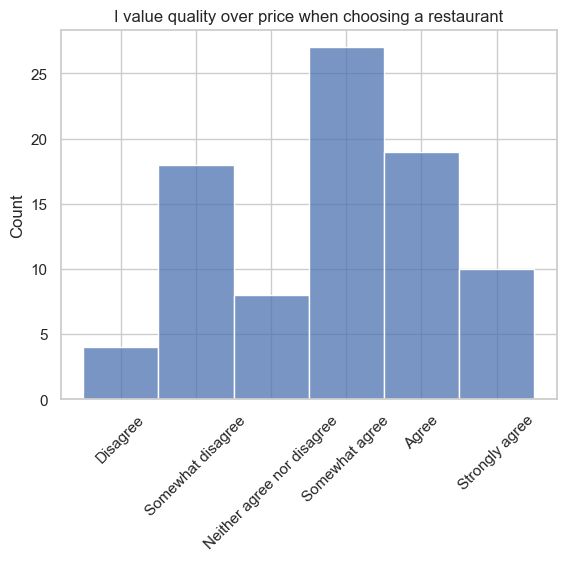

In [32]:
categories = [
    "Strongly disagree",
    "Disagree",
    "Somewhat disagree",
    "Neither agree nor disagree",
    "Somewhat agree",
    "Agree",
    "Strongly agree"
]

question_2 = pd.Categorical(survey_data['Q2_1'], categories=categories, ordered=True)

# question_2 = survey_data['Q2_1']
sns.histplot(question_2)
plt.xticks(rotation=45)
plt.title("I value quality over price when choosing a restaurant")
plt.show()

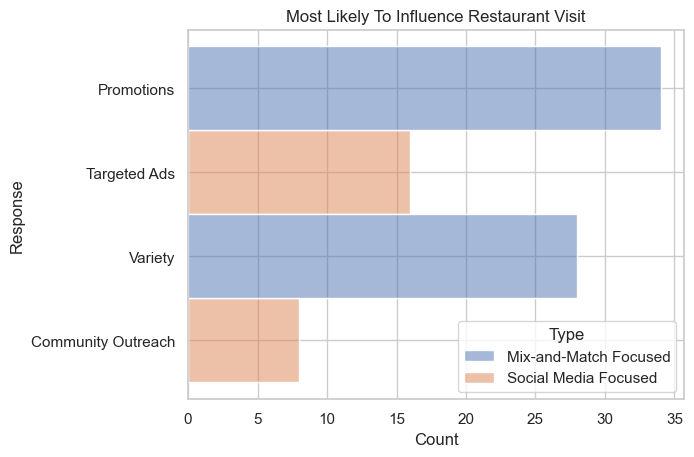

In [33]:
results_key = {
    'Special': 'Promotions',
    'Opportunities': 'Variety',
    'Seeing': 'Targeted Ads',
    'Community': 'Community Outreach'

}

q3_results = survey_data[['Q3']].rename(columns={'Q3': 'Response'})
q3_results['Response'] = (q3_results['Response']
                          .str.split()
                          .str[0]
                          .map(results_key))

q3_results.loc[q3_results['Response'].isin(['Promotions', 'Variety']),'Type'] = 'Mix-and-Match Focused'
q3_results.loc[q3_results['Response'].isin(['Targeted Ads', 'Community Outreach']),'Type'] = 'Social Media Focused'

q3_results
sns.histplot(q3_results, y='Response', hue='Type')
plt.title("Most Likely To Influence Restaurant Visit")
plt.show()


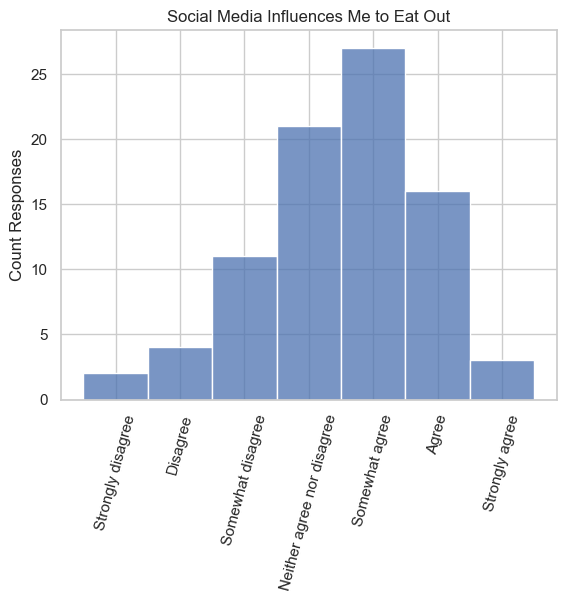

In [34]:
question_4 = pd.Categorical(survey_data['Q4_1'], categories=categories, ordered=True)
sns.histplot(question_4)
plt.xticks(rotation=75)
plt.title("Social Media Influences Me to Eat Out")
plt.ylabel("Count Responses")
plt.show()

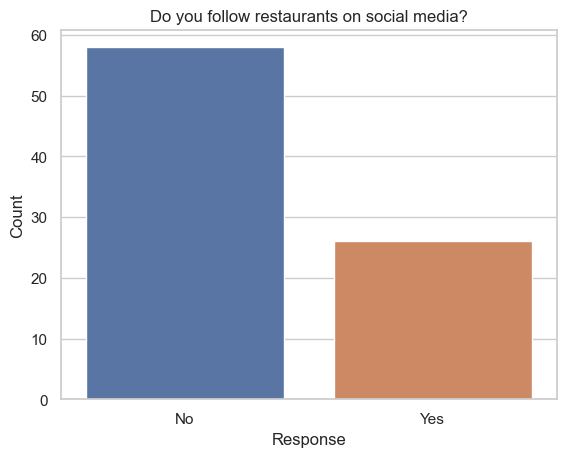

In [35]:
q5_responses = survey_data[['Q5']]
q5_group = q5_responses.groupby('Q5').size().reset_index().rename(columns={0: 'Count'})
sns.barplot(data=q5_group, x='Q5', y='Count')
plt.xlabel('Response')
plt.title('Do you follow restaurants on social media?')
plt.show()

# Part 4: Bundle Deals
## Pricing Sentiment Analysis

In [36]:
data = r'C:\Users\User\Desktop\Class Stuff\DCSI 311\Homework\Homework 5\vader_lexicon.txt'
sent = pd.read_csv(data, sep='\t', header=None).rename(columns={0:'word', 1:'polarity'}).reset_index()
sent = sent[['word', 'polarity']]
sent.set_index('word', inplace=True)
print(f'The length of the polarity dataset is: {len(sent)} words')
sent.head(10)

The length of the polarity dataset is: 7517 words


,polarity
word,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7
( '}{' ),1.6
(%,-0.9
('-:,2.2
(':,2.3


In [37]:
survey_menu_thoughts = survey_data[['Q13', 'MenuVersion']].rename(columns={'Q13': 'Response'})

pat = '[^A-Za-z]'
survey_menu_thoughts['Response'] = (survey_menu_thoughts['Response']
                                    .str.replace(pat, ' ', regex=True)
                                    .str.lower()
                                    )
survey_menu_thoughts.head(5)


,Response,MenuVersion
0,lots of different tacos,No Deal
1,they look good but also tacos i could just mak...,Deal Included
2,very well spread healthy and accesable,No Deal
3,it looks like there is a good amount of option...,Deal Included
4,good descriptions and mix of food the letteri...,Deal Included


In [38]:
tidy_thoughts = (survey_menu_thoughts['Response']
                 .str.split(expand=True)
                 .stack()
                 .reset_index(level=1)
                 .rename(columns={0:'word', 'level_1':'num'}, inplace=False)
                 )
tidy_thoughts

,num,word
0,0,lots
0,1,of
0,2,different
0,3,tacos
1,0,they
...,...,...
83,1,but
83,2,looks
83,3,okay
83,4,very


In [39]:
thoughts_polarity = tidy_thoughts.merge(sent, left_on='word', right_index=True, how='left')

thoughts_polarity['polarity'].fillna(
    value=0, 
    inplace=True)

thoughts_polarity_total = thoughts_polarity.groupby(level=0)['polarity'].sum()

survey_menu_thoughts['sentiment'] = thoughts_polarity_total

positive_responses = survey_menu_thoughts.sort_values(by='sentiment', ascending=False)
survey_menu_thoughts['sentiment']


0     0.0
1     1.9
2     2.8
3     4.9
4     1.9
     ... 
84    NaN
85    NaN
86    NaN
87    NaN
88    NaN
Name: sentiment, Length: 89, dtype: float64

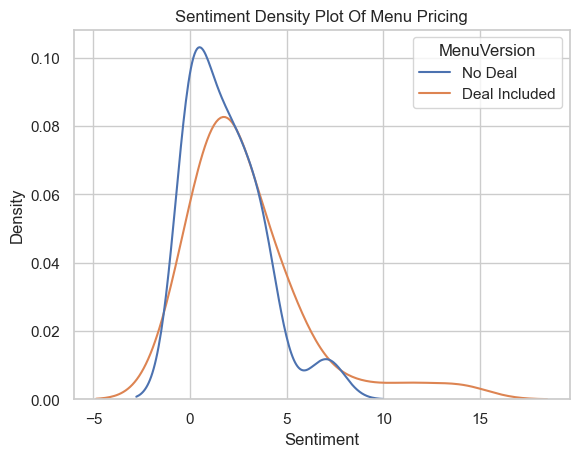

In [40]:
sns.set_theme(style='whitegrid')
sns.kdeplot(survey_menu_thoughts, x='sentiment', hue='MenuVersion')
plt.title('Sentiment Density Plot Of Menu Pricing')
plt.xlabel('Sentiment')
plt.show()

In [41]:
from scipy.stats import ttest_ind

deal_thoughts = survey_menu_thoughts[survey_menu_thoughts['MenuVersion'] == 'Deal Included']['sentiment'].dropna()
no_deal_thoughts = survey_menu_thoughts[survey_menu_thoughts['MenuVersion'] == 'No Deal']['sentiment'].dropna()

t_stat, p_value = ttest_ind(deal_thoughts, no_deal_thoughts, equal_var=False)
t_stat, p_value

(1.7906982379278555, 0.07835401297864322)

- Currently, menu A has more positive reviews on pricing compared to menu B. Menu A is the menu incorperating the mix and match option. Now, let,s see if that correlates with a higher average spending rate.

,count,mean,std,min,25%,50%,75%,max
MenuVersion,,,,,,,,
Deal Included,37.0,13.72973,4.862833,5.0,13.0,13.0,15.0,30.0
No Deal,36.0,11.00000,4.659859,4.0,7.5,10.0,15.0,20.0


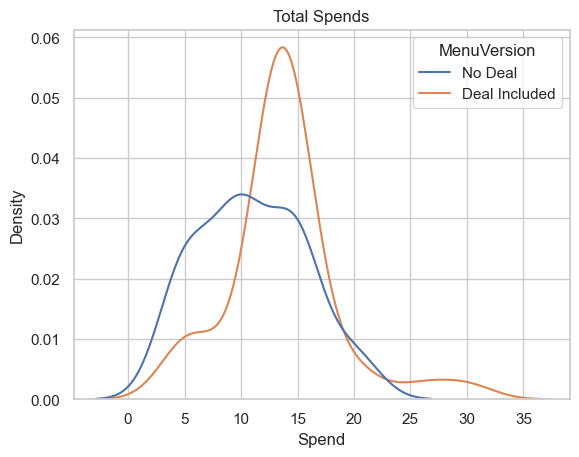

In [83]:
spending = survey_data[['Q11', 'MenuVersion']].rename(columns={'Q11': "Spend"})
spending_averages = spending.groupby('MenuVersion')['Spend'].describe()
display(spending_averages)
sns.set_theme(style='whitegrid')
sns.kdeplot(
    data=spending,
    x='Spend',
    hue='MenuVersion'
)

plt.title('Total Spends')
plt.show()


In [43]:
import pandas as pd


# Perform grouping and descriptive statistics
spending = survey_data[['Q11', 'MenuVersion']].rename(columns={'Q11': "Spend"})
spending_averages = spending.groupby('MenuVersion')['Spend'].describe()

display(spending_averages)

# Perform t-test
group_a = spending[spending['MenuVersion'] == spending['MenuVersion'].unique()[0]]['Spend'].dropna()
group_b = spending[spending['MenuVersion'] == spending['MenuVersion'].unique()[1]]['Spend'].dropna()

t_stat, p_value = ttest_ind(group_a, group_b, equal_var=False)

t_stat, p_value


,count,mean,std,min,25%,50%,75%,max
MenuVersion,,,,,,,,
Deal Included,37.0,13.72973,4.862833,5.0,13.0,13.0,15.0,30.0
No Deal,36.0,11.00000,4.659859,4.0,7.5,10.0,15.0,20.0


(-2.44911249457593, 0.016791673345622607)

This is the part that got me. I was going to to some calculations using order choices, but that got ruined. There's not much I can do with the "What would you order?" question. It was worded horribly. Mistake on my part for not communicating correctly. Kinda hurts to put my name on that survey though. Especially since I put so much time into the original. (Side note: All of the questions I designed the analysis is going perfectly for. I could've handeled the extra columns from split questions. )

In [44]:
for item in survey_data['Q12']:
    print(item)
# Data cleaning nightmare... Faster to clean by hand

Tacos
Grilled Chicken, Old E, Mole Verde
3 ish separate tacos 
Mix and match tacos
3 mix and match tacos
Steak tacos
Shrimp
3 grilled chicken tacos
2 Carne Tacos
3 tacos
Grilled Chicken
Shrimp, Grilled Chicken, Carne Asada 
2 grilled chick
Carnitas, chicken, and steak tacos
6 tacos
Mix & Match
Pork chorizo
E x 2 and then B
Carnitas 
Mix-&-Match Any 3 Tacos
3 tacos 
Carne Asada
G, k
Mushroom, Carne Asada
carne asada, grilled chicken, pork chorizo
2 carnitas tacos and a pork chorizo taco
3 carne asadas
Quesadilla 
1 Carnitas and 2 carne asada 
I would get grilled chicken and carne asada tacos
Carne asada
Grilled chicken and tofu
K, C, A
Grilled chicken 
carnitas
Pescado
Pork Chorizo
carne asada and pescado
ADI
I would get a chicken taco, a shrimp taco, and a carne asada taco
Grilled Chiken
Chicken
Grilled chicken 
Shrimp
AFK
Shrimp and grilled chicken
3 carne asadas
the carne asafa
Grilled chicken 
C, E, H
Carnitas, Carne Asada, and shrimp tacos
shrimp, carne asada
The mix&match of 2 A’s

# Part 5: Instagram Posts

In [45]:
instagram_data = survey_data[['Q8_1', 'Q8_2', 'Q8_3', 'InstagramVersion']].rename(columns={'Q8_1':'Stands out?', 'Q8_2':'Visually appealing?', 'Q8_3':'Influential?'})

response_map = {
    'Strongly disagree': -2,
    'Somewhat disagree': -1,
    'Neither agree nor disagree': 0,
    'Somewhat agree': 1,
    'Strongly agree': 2
}


instagram_data['Stands out? #'] = instagram_data['Stands out?'].map(response_map)
instagram_data['Visually appealing? #'] = instagram_data['Visually appealing?'].map(response_map)
instagram_data['Influential? #'] = instagram_data['Influential?'].map(response_map)

instagram_data.head(5)

,Stands out?,Visually appealing?,Influential?,InstagramVersion,Stands out? #,Visually appealing? #,Influential? #
0,Somewhat agree,Strongly agree,Strongly agree,Reel,1.0,2.0,2.0
1,Strongly disagree,Strongly disagree,Strongly disagree,Reel,-2.0,-2.0,-2.0
2,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Post,0.0,0.0,0.0
3,Neither agree nor disagree,Somewhat disagree,Neither agree nor disagree,Post,0.0,-1.0,0.0
4,Somewhat agree,Strongly agree,Somewhat agree,Reel,1.0,2.0,1.0


In [46]:
# Select the relevant columns
instagram_data_qual = instagram_data.iloc[:, :4]

# Melt the DataFrame to long format
response_melt = instagram_data_qual.melt(
    id_vars=["InstagramVersion"], 
    var_name="Question", 
    value_name="Response")

# Use crosstab to compute the counts
count_pivot = pd.crosstab(
    [response_melt['Question'], response_melt['InstagramVersion']],
    response_melt['Response']
)

display(count_pivot)

# Reorder the columns if necessary
desired_order = [
    'Strongly disagree',
    'Somewhat disagree',
    'Neither agree nor disagree',
    'Somewhat agree',
    'Strongly agree'
]
count_pivot = count_pivot.reindex(columns=desired_order).reset_index()

long_df = count_pivot.melt(
    id_vars=['Question', 'InstagramVersion'],
    var_name='Response',
    value_name='Count'
)

# Display the result
long_df.head(10)

Response                              Neither agree nor disagree  \
Question            InstagramVersion                               
Influential?        Post                                      15   
                    Reel                                       7   
Stands out?         Post                                      10   
                    Reel                                       8   
Visually appealing? Post                                      14   
                    Reel                                       5   

Response                              Somewhat agree  Somewhat disagree  \
Question            InstagramVersion                                      
Influential?        Post                          11                  8   
                    Reel                          21                  6   
Stands out?         Post                           8                 13   
                    Reel                          17                 10   
Visually appealing? Post                          11                  8   
                    Reel                          19                  7   

Response                              Strongly agree  Strongly disagree  
Question            InstagramVersion                                     
Influential?        Post                           4                  3  
                    Reel                           4                  5  
Stands out?         Post                           5                  4  
                    Reel                           3                  5  
Visually appealing? Post                           7                  1  
                    Reel                           7                  5

,Question,InstagramVersion,Response,Count
0,Influential?,Post,Strongly disagree,3
1,Influential?,Reel,Strongly disagree,5
2,Stands out?,Post,Strongly disagree,4
3,Stands out?,Reel,Strongly disagree,5
4,Visually appealing?,Post,Strongly disagree,1
5,Visually appealing?,Reel,Strongly disagree,5
6,Influential?,Post,Somewhat disagree,8
7,Influential?,Reel,Somewhat disagree,6
8,Stands out?,Post,Somewhat disagree,13
9,Stands out?,Reel,Somewhat disagree,10


c:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


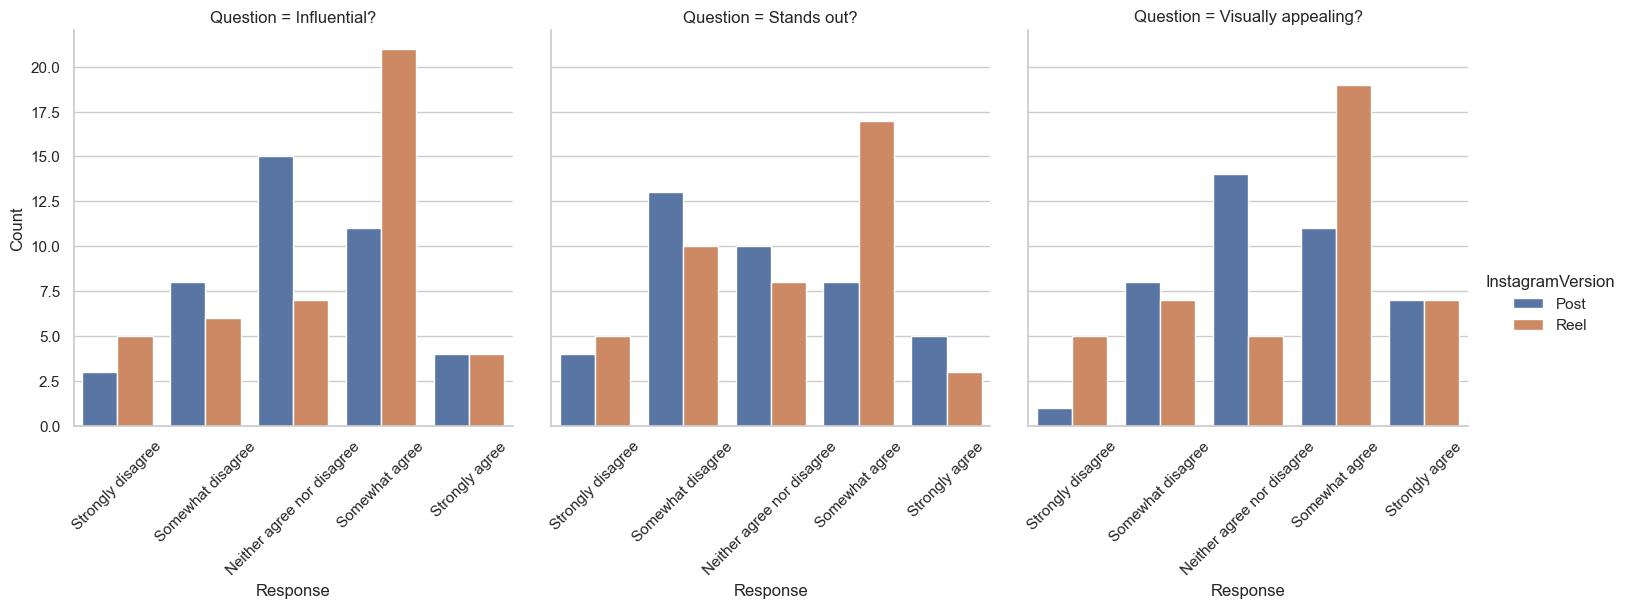

c:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


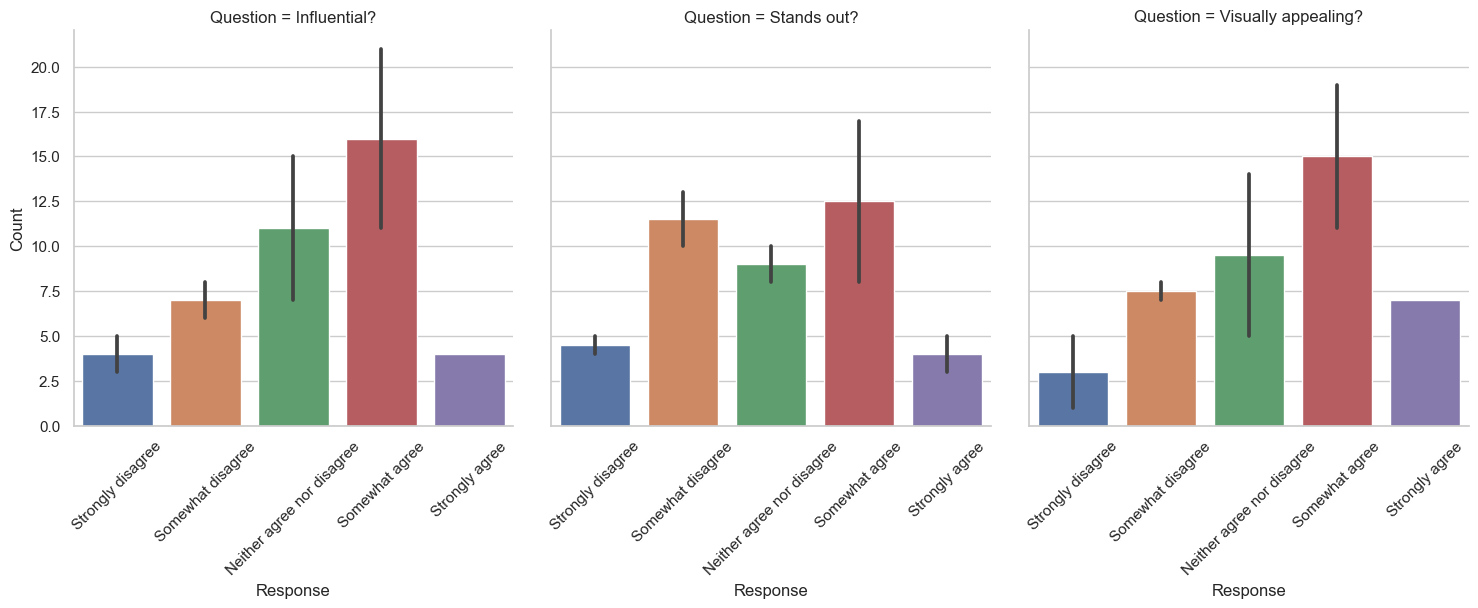

In [47]:
# Create a bar plot for each question
g = sns.catplot(
    data=long_df,
    x='Response',
    y='Count',
    hue='InstagramVersion',
    col='Question',
    kind='bar',
)

g.set_xticklabels(rotation=45)
# plt.legend()

plt.show()

# Create a bar plot for each question
g = sns.catplot(
    data=long_df,
    x='Response',
    y='Count',
    col='Question',
    kind='bar',
)

g.set_xticklabels(rotation=45)
# plt.legend()

plt.show()


Error bars indicate consistancy amoung responses in a catrgory. Thows how much the counts can vary across multiple samples.

In [48]:
numeric_instagram = pd.DataFrame()

numeric_instagram['InstagramVersion'] = instagram_data['InstagramVersion']

for column in ['Stands out?', 'Visually appealing?', 'Influential?']:
    numeric_instagram[column] = instagram_data[column].map(response_map)

numeric_instagram.head(10)

,InstagramVersion,Stands out?,Visually appealing?,Influential?
0,Reel,1.0,2.0,2.0
1,Reel,-2.0,-2.0,-2.0
2,Post,0.0,0.0,0.0
3,Post,0.0,-1.0,0.0
4,Reel,1.0,2.0,1.0
5,Post,2.0,2.0,2.0
6,Post,1.0,1.0,0.0
7,Reel,1.0,1.0,1.0
8,Reel,-1.0,2.0,1.0
9,Post,1.0,2.0,1.0


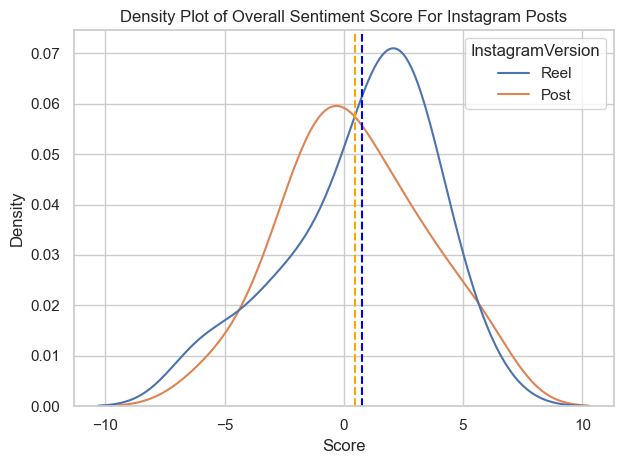

In [49]:
numeric_instagram['Score'] = (
    numeric_instagram['Stands out?'] + 
    numeric_instagram['Visually appealing?'] + 
    numeric_instagram['Influential?'])

mean_reel = numeric_instagram[numeric_instagram['InstagramVersion'] == 'Reel']['Score'].mean()
mean_post = numeric_instagram[numeric_instagram['InstagramVersion'] == 'Post']['Score'].mean()

sns.set_theme(style='whitegrid')
sns.kdeplot(data=numeric_instagram, x='Score', hue='InstagramVersion')
plt.title("Density Plot of Overall Sentiment Score For Instagram Posts")
plt.axvline(
    x=mean_reel, 
    linestyle='--', 
    color='blue', 
    label=f'Mean Reel Score{np.round(mean_reel, 2)}')

plt.axvline(
    x=mean_post, 
    linestyle='--', 
    color='orange',
    label=f'Mean Post Score{np.round(mean_reel, 2)}')
plt.tight_layout()
plt.show()

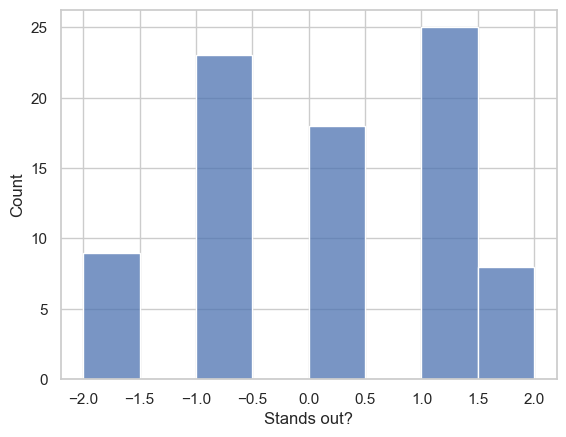

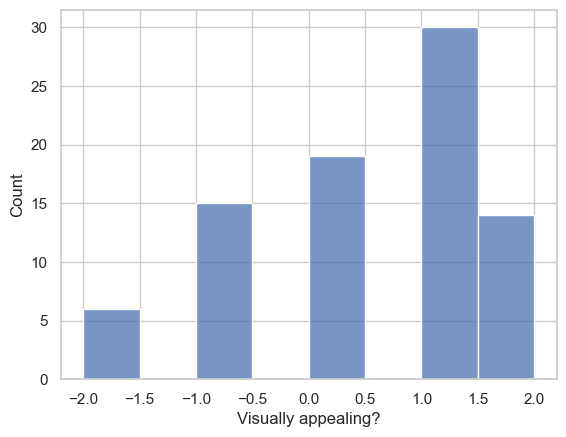

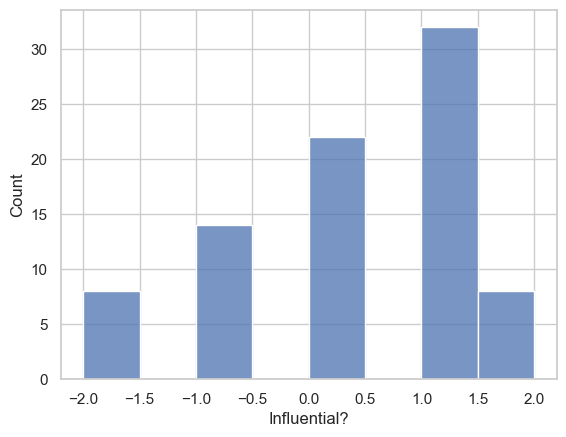

,InstagramVersion,Stands out?,Visually appealing?,Influential?,Score,Average Score
0,Reel,1.0,2.0,2.0,5.0,17.0
1,Reel,-2.0,-2.0,-2.0,-6.0,-24.0
2,Post,0.0,0.0,0.0,0.0,0.0
3,Post,0.0,-1.0,0.0,-1.0,-1.0
4,Reel,1.0,2.0,1.0,4.0,10.0
...,...,...,...,...,...,...
84,Post,-1.0,-1.0,0.0,-2.0,-2.0
85,NaN,NaN,NaN,NaN,NaN,NaN
86,Post,-1.0,0.0,0.0,-1.0,-1.0
87,NaN,NaN,NaN,NaN,NaN,NaN


(-0.4790909947570922, 0.6331505371697894)

In [80]:
from scipy.stats import ttest_ind
sns.histplot(numeric_instagram['Stands out?'])
plt.show()

sns.histplot(numeric_instagram['Visually appealing?'])
plt.show()

sns.histplot(numeric_instagram['Influential?'])
plt.show()


numeric_instagram['Average Score'] = (
    numeric_instagram['Stands out?'] ** 3 + 
    numeric_instagram['Visually appealing?'] ** 3 + 
    numeric_instagram['Influential?'] ** 3) 


display(numeric_instagram)


reel_scores = numeric_instagram[numeric_instagram['InstagramVersion'] == 'Reel']['Average Score'].fillna(0)
post_scores = numeric_instagram[numeric_instagram['InstagramVersion'] == 'Post']['Average Score'].fillna(0)


t_stat, p_value = ttest_ind(reel_scores, post_scores, equal_var=False)
t_stat, p_value

- This indicates a simple social media based marketing approach results in generally positive sentiment and should be looked into more regarding advertising towards college students.
- No statistically significant difference.


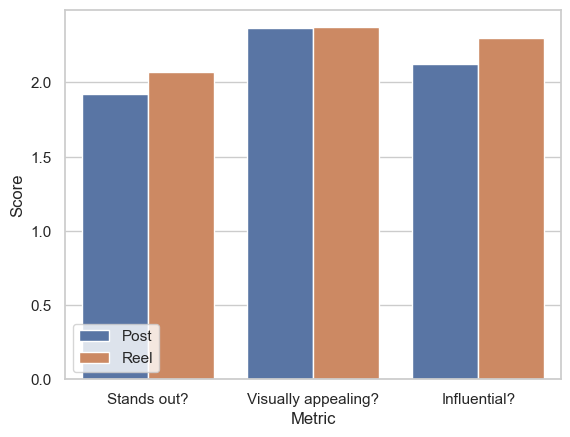

In [51]:
scores_instagram_5 = pd.DataFrame()
scores_instagram_5['InstagramVersion'] = instagram_data['InstagramVersion']
for column in ['Stands out?', 'Visually appealing?', 'Influential?']:
    scores_instagram_5[column] = numeric_instagram[column] + 2

scores_instagram_5.head(10)

grouped_scores_5 = scores_instagram_5.groupby('InstagramVersion').mean().reset_index()
melted_scores = grouped_scores_5.melt(id_vars='InstagramVersion', var_name='Metric', value_name='Score')

sns.barplot(data=melted_scores, x='Metric', y='Score', hue='InstagramVersion')
plt.legend(loc='lower left')
plt.show()

# Linear Relationships?

In [52]:
survey_data.head()

,DistributionChannel,Q2_1,Q3,Q4_1,Q5,Q8_1,Q8_2,Q8_3,Q11,Q12,Q13,Q14_1,Q15,Q16,Q16_3_TEXT,InstagramVersion,MenuVersion
0,anonymous,Somewhat agree,Special promotions or discounts.,Agree,No,Somewhat agree,Strongly agree,Strongly agree,15.0,Tacos,Lots of different tacos,2,3rd Year,Male,NaN,Reel,No Deal
1,anonymous,Agree,Seeing a targeted advertisement on social media.,Neither agree nor disagree,No,Strongly disagree,Strongly disagree,Strongly disagree,15.0,"Grilled Chicken, Old E, Mole Verde",They look good but also tacos I could just mak...,2,3rd Year,Female,NaN,Reel,Deal Included
2,anonymous,Agree,Opportunities to try a wider variety of food o...,Neither agree nor disagree,Yes,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,15.0,3 ish separate tacos,Very well spread healthy and accesable,1,3rd Year,Male,NaN,Post,No Deal
3,anonymous,Somewhat disagree,Special promotions or discounts.,Agree,Yes,Neither agree nor disagree,Somewhat disagree,Neither agree nor disagree,13.0,Mix and match tacos,It looks like there is a good amount of option...,2,3rd Year,Male,NaN,Post,Deal Included
4,anonymous,Neither agree nor disagree,Special promotions or discounts.,Disagree,No,Somewhat agree,Strongly agree,Somewhat agree,13.0,3 mix and match tacos,Good descriptions and mix of food. The letteri...,2,3rd Year,Male,NaN,Reel,Deal Included


In [53]:
response_map_5 = {
    'Strongly disagree': -2,
    'Somewhat disagree': -1,
    'Neither agree nor disagree': 0,
    'Somewhat agree': 1,
    'Strongly agree': 2
}

response_map_7 = {
    "Strongly disagree": -3,
    "Disagree": -2,
    "Somewhat disagree": -1,
    "Neither agree nor disagree": 0,
    "Somewhat agree": 1,
    "Agree": 2,
    "Strongly agree": 3
}

binary = {
    'Yes': 1,
    'No': 0
}

In [54]:
linear_data = survey_data.copy()
linear_data.drop(columns=['Q16_3_TEXT'], inplace=True)

linear_data['Q15'] = (linear_data['Q15']
                      .fillna('0')
                      .str.extract(r'(\d+)')
                      .astype(int))
linear_data['Q2_1'] = linear_data['Q2_1'].map(response_map_7)
linear_data['Q4_1'] = linear_data['Q4_1'].map(response_map_7)
linear_data['Q5'] = linear_data['Q5'].map(binary)
linear_data['Q8_1'] = linear_data['Q8_1'].map(response_map_5)
linear_data['Q8_2'] = linear_data['Q8_2'].map(response_map_5)
linear_data['Q8_3'] = linear_data['Q8_3'].map(response_map_5)

linear_data['sentiment'] = survey_menu_thoughts['sentiment']

linear_data.rename(columns={
    'Q2_1': 'Quality > Price',
    'Q3': 'Interests you the most?',
    'Q4_1': 'Ads are Influential', 
    'Q5': "Follow Restaurants", 
    'Q8_1': 'Stand Out?',
    'Q8_2': 'Visually Appealing',
    'Q8_3': 'Influential?',
    'Q11': 'Spend',
    'Q12': "Order?",
    'Q13': 'Menu Thoughts',
    'Q14_1': 'Weekly Eating Out',
    'Q15': 'Years as Student',
    'Q16': 'Gender'
    }, inplace=True)

linear_data.fillna(0)
linear_data.head(2)


,DistributionChannel,Quality > Price,Interests you the most?,Ads are Influential,Follow Restaurants,Stand Out?,Visually Appealing,Influential?,Spend,Order?,Menu Thoughts,Weekly Eating Out,Years as Student,Gender,InstagramVersion,MenuVersion,sentiment
0,anonymous,1.0,Special promotions or discounts.,2.0,0.0,1.0,2.0,2.0,15.0,Tacos,Lots of different tacos,2,3,Male,Reel,No Deal,0.0
1,anonymous,2.0,Seeing a targeted advertisement on social media.,0.0,0.0,-2.0,-2.0,-2.0,15.0,"Grilled Chicken, Old E, Mole Verde",They look good but also tacos I could just mak...,2,3,Female,Reel,Deal Included,1.9


In [55]:
# survey_data = data.copy()

file_name = r'./data/MKTG390_Group2_Tacovore_Data.xlsx'

with pd.ExcelWriter(file_name, engine='openpyxl') as writer:
    raw_data.to_excel(writer, sheet_name='Raw Data', index=False)
    linear_data.to_excel(writer, sheet_name='Clean Data', index=False) 

c:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


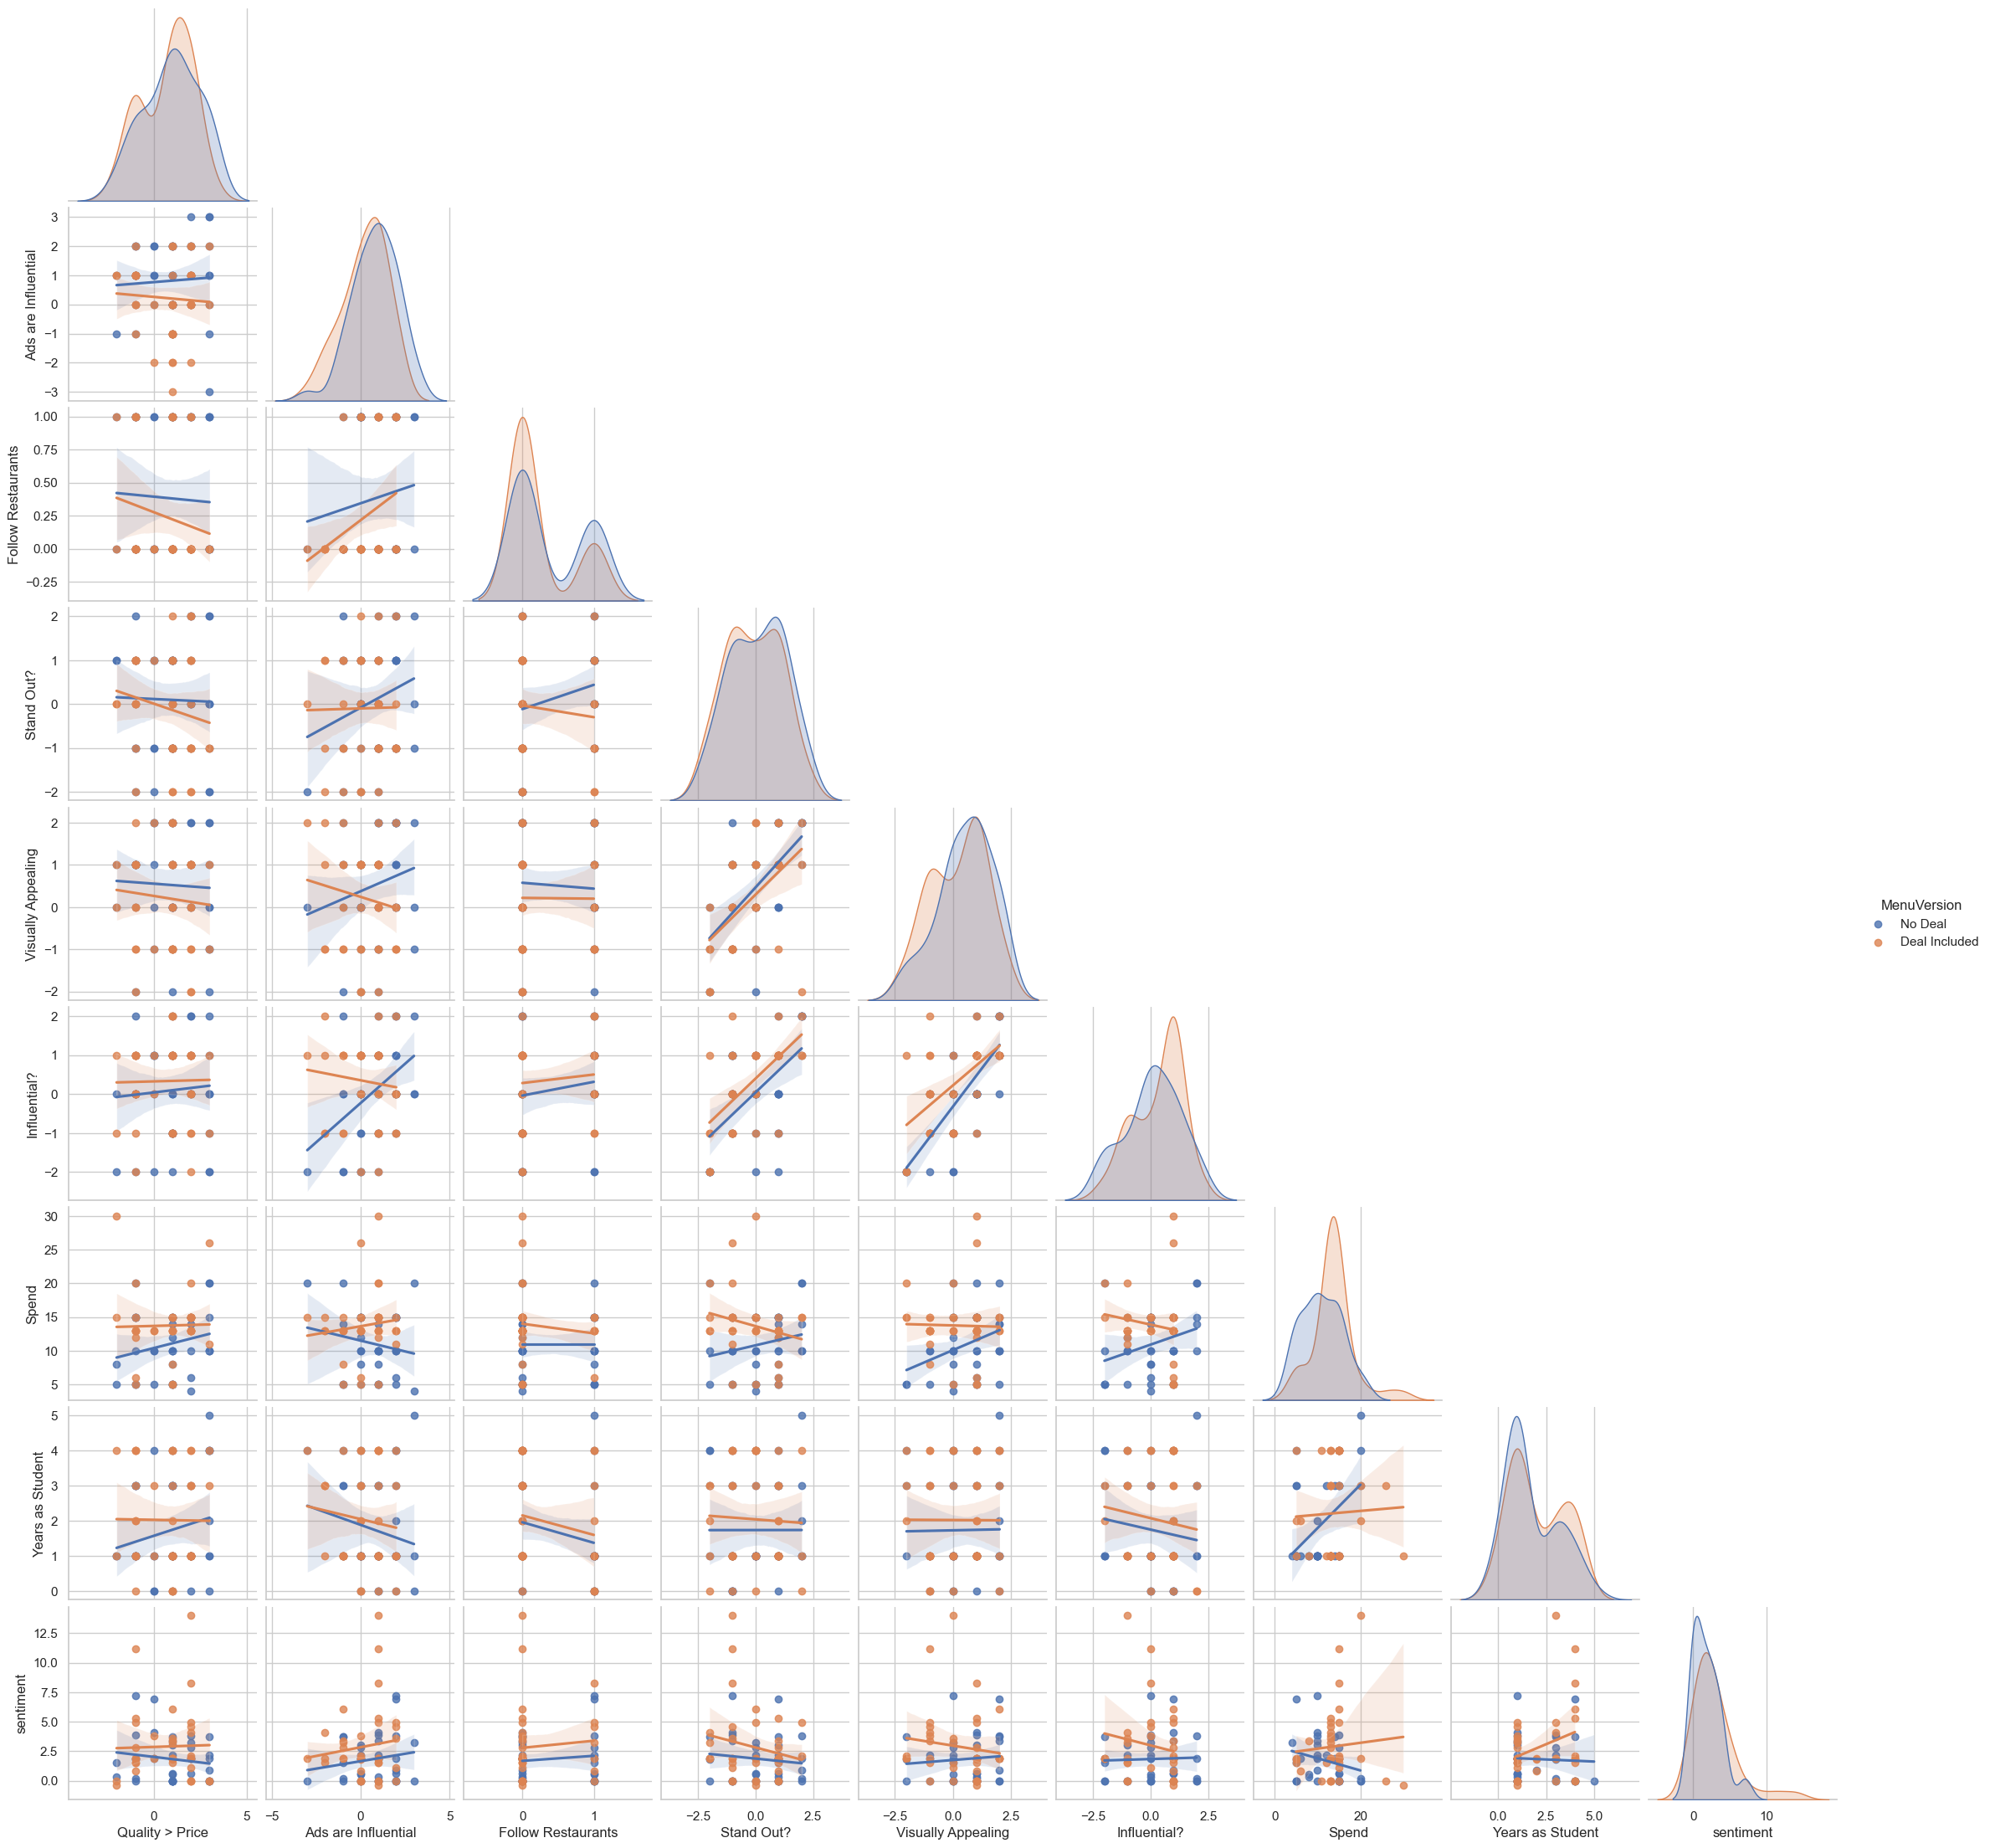

In [56]:
sns.pairplot(
    linear_data, 
    corner=True, 
    kind='reg', hue='MenuVersion')
plt.show()

In [57]:
from scipy.stats import linregress

In [58]:
deal_data = linear_data[linear_data['MenuVersion'] == 'Deal Included']
deal_data = deal_data.dropna(subset=['sentiment', 'Spend'])

deal_slope, deal_intercept, deal_r, deal_p, deal_sterr = linregress(x=deal_data['Spend'], y=deal_data['sentiment'])
print(f"The equation of the regression is roughly: {round(deal_slope, 4)}x + {round(deal_intercept, 3)}")
print(f'The correlation coefficient of the regression is {deal_r}')
print(f'The p-value associated with the test hypothesis that the slope is 0 is: {deal_p}')
print(f'The standard error is {deal_sterr} \n')


no_deal_data = linear_data[linear_data['MenuVersion'] == 'No Deal']
no_deal_data = no_deal_data.dropna(subset=['sentiment', 'Spend'])

slope, intercept, r, p, sterr = linregress(x=no_deal_data['sentiment'], y=no_deal_data['Spend'])
print(f"The equation of the regression is roughly: {round(slope, 4)}x + {round(intercept, 3)}")
print(f'The correlation coefficient of the regression is {r}')
print(f'The p-value associated with the test hypothesis that the slope is 0 is: {p}')
print(f'The standard error is {sterr}')

The equation of the regression is roughly: 0.0498x + 2.214
The correlation coefficient of the regression is 0.0791139127377503
The p-value associated with the test hypothesis that the slope is 0 is: 0.6416129506011641
The standard error is 0.10601257832466147 

The equation of the regression is roughly: -0.6089x + 12.255
The correlation coefficient of the regression is -0.2506318816836676
The p-value associated with the test hypothesis that the slope is 0 is: 0.14644503920816146
The standard error is 0.40944017507881314


c:\Users\User\anaconda3\Lib\site-packages\seaborn\regression.py:582: UserWarning: legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
c:\Users\User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\User\AppData\Local\Temp\ipykernel_9924\2583165825.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Ensure nothing is cut off


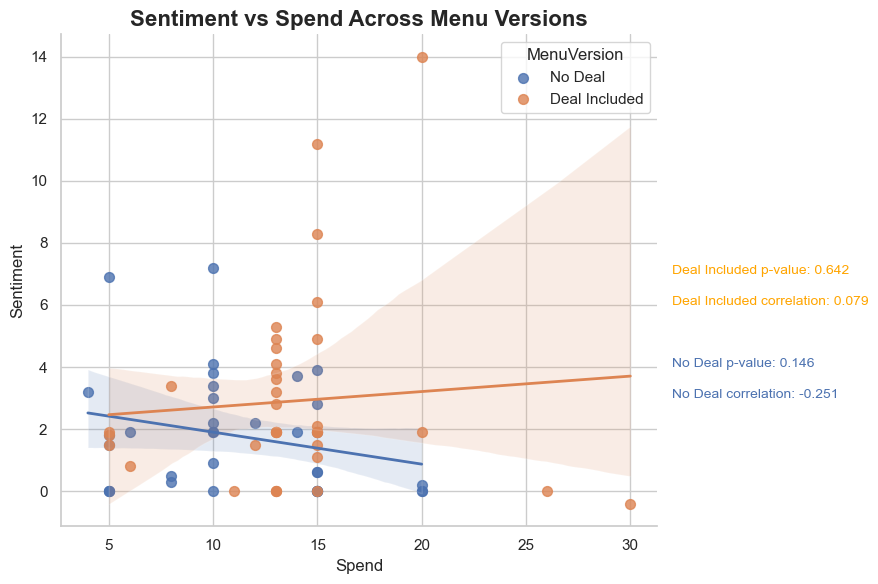

In [59]:
sns.set_theme(style="whitegrid")  # Apply Seaborn style
sns.lmplot(data=linear_data, x='Spend', y='sentiment', hue='MenuVersion', 
           height=6, aspect=1.5, scatter_kws={'s': 50}, line_kws={'lw': 2},
           legend=True, legend_out=False)

# Customize title and labels
plt.title("Sentiment vs Spend Across Menu Versions", fontsize=16, fontweight='bold')
plt.xlabel("Spend", fontsize=12)
plt.ylabel("Sentiment", fontsize=12)

# Adding comments
plt.text(32, 7, f'Deal Included p-value: {np.round(deal_p, 3)}', fontsize=10, color='orange')
plt.text(32, 6, f'Deal Included correlation: {np.round(deal_r, 3)}', fontsize=10, color='orange')

plt.text(32, 4, f'No Deal p-value: {np.round(p, 3)}', fontsize=10, color='b')
plt.text(32, 3, f'No Deal correlation: {np.round(r, 3)}', fontsize=10, color='b')

# # Adjust axis limits if needed
# plt.xlim(0, 50)  # Example: Replace with meaningful values
# plt.ylim(10, 20)  # Example: Replace with meaningful values

# Final adjustments
# plt.legend(title='Menu Version', loc='best', fontsize=10)
plt.tight_layout()  # Ensure nothing is cut off

# Display the plot
plt.show()
